In [230]:
%matplotlib inline 

import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import mpld3

In [232]:
matplotlib.style.use('ggplot')
mpld3.enable_notebook()

In [93]:
df_initial = quandl.get('WIKI/GOOGL')

In [233]:
df = df_initial.copy()

In [234]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_percent'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100
df['day_percent'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100
df = df[['Adj. Close', 'HL_percent', 'day_percent']]

In [235]:
print df.tail()

            Adj. Close  HL_percent  day_percent
Date                                           
2017-07-17      975.96    1.292748    -0.036873
2017-07-18      986.95    1.935106     1.396195
2017-07-19      992.77    0.870305     0.278785
2017-07-20      992.19    1.427962    -0.482447
2017-07-21      993.84    1.111597     0.489383


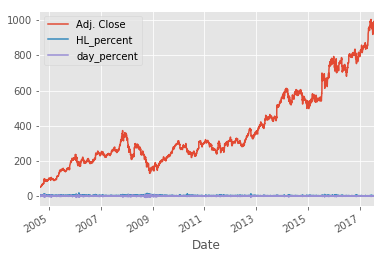

In [236]:
df.plot();

In [237]:
forecast_col = 'Adj. Close'
df.fillna(-9999999, inplace=True)
forecast_days = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_days)
print "Getting predictions for %d days in advance\n"%forecast_days
print df.head()

Getting predictions for 33 days in advance

            Adj. Close  HL_percent  day_percent      label
Date                                                      
2004-08-19   50.322842    8.441017     0.324968  68.752232
2004-08-20   54.322689    8.537313     7.227007  69.639972
2004-08-23   54.869377    4.062357    -1.227880  69.078238
2004-08-24   52.597363    7.753210    -5.726357  67.839414
2004-08-25   53.164113    3.966115     1.183658  68.912727


In [238]:
x = np.array(df.drop(['label'], 1))
x = preprocessing.scale(x)
x_lately = x[-forecast_days:]
x = x[:-forecast_days]

df.dropna(inplace=True)
y = np.array(df['label'])

#Make sure that the length of x and y are equal
print len(x), len(y)

3221 3221


In [239]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2)

In [240]:
clf = LinearRegression()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print "Linear Regression Accuracy is : %.2f%%"%(accuracy*100)

Linear Regression Accuracy is : 96.85%


In [241]:
#Just for comparison. Not used anywhere else
_clf = svm.SVR()
_clf.fit(x_train, y_train)
_accuracy = _clf.score(x_test, y_test)
print "SVM Regression Accuracy is : %.2f%%"%(_accuracy*100)

SVM Regression Accuracy is : 82.04%


In [242]:
#Start actually predicting the values for last forecast_days
forecast_values = clf.predict(x_lately)
print "%s for last %d days is %s with an accuracy of %.2f%%"%(forecast_col, forecast_days, forecast_values, accuracy*100)

Adj. Close for last 33 days is [ 1015.23706026  1021.52449479  1024.01023802   980.11515448   976.69276684
   988.39315908   984.79253901   977.44511947   977.27682801   994.3041969
   987.35973299   997.89604062   996.28644245  1005.27715577   988.09812293
   964.47940853   976.90063169   953.62583081   946.65568442   935.57078593
   949.48178294   944.95867419   958.77881627   969.81731136   972.46882953
   986.3811519    986.95599755   996.63217646   994.61006039  1004.99350724
  1012.49025827  1010.67031585  1013.19807419] with an accuracy of 96.85%


In [243]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
one_day = pd.to_timedelta(24, unit='h')
next_date = last_date + one_day

for day_forecast in forecast_values:
    next_date += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [day_forecast]

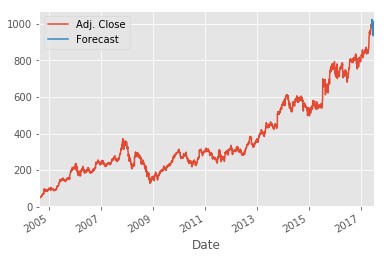

In [244]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)